<a href="https://colab.research.google.com/github/hailuu684/ComputerVisionHomeWork/blob/free_space_segmentation/free_space_using_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
# from tensorflow.keras import layers
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(11)


In [ ]:
means = [[2, 2], [8, 3], [3, 6],[4,9]]
cov = [[1, 0], [0, 1]]
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)
X3 = np.random.multivariate_normal(means[3],cov,N)
X = np.concatenate((X0, X1, X2,X3), axis = 0)
K = 4

original_label = np.asarray([0]*N + [1]*N + [2]*N + [3]*N).T

In [ ]:
def kmeans_display(X, label):
    K = np.amax(label) + 1
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    X3 = X[label == 3, :]
    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8)
    plt.plot(X3[:, 0], X3[:, 1], 's', markersize = 4, alpha = .8)

    plt.axis('equal')
    plt.plot()
    plt.show()

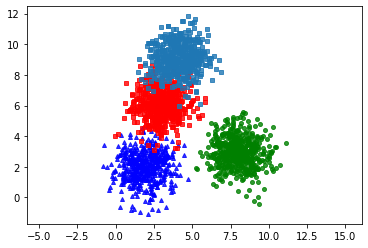

In [ ]:
ori_data = kmeans_display(X, original_label)

In [ ]:
def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster 
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) == 
        set([tuple(a) for a in new_centers]))
    
def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0 
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

Centers found by our algorithm:
[[2.95914333 6.10816823]
 [1.90467525 2.00082976]
 [4.11013022 9.11771891]
 [7.97753493 2.95949888]]
4


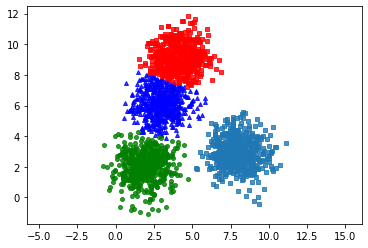

In [ ]:
(centers, labels, it) = kmeans(X, K)
print('Centers found by our algorithm:')
print(centers[-1])
print(it)
kmeans_display(X, labels[-1])


Centers found by scikit-learn:
[[7.97753493 2.95949888]
 [2.95810869 6.10518243]
 [4.10885391 9.11467246]
 [1.90467525 2.00082976]]


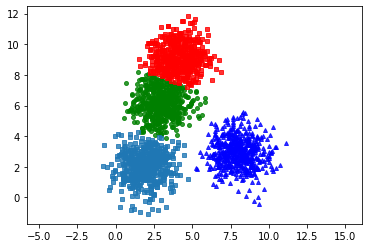

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
print('Centers found by scikit-learn:')
print(kmeans.cluster_centers_)
pred_label = kmeans.predict(X)
data_found = kmeans_display(X, pred_label)

# find x,y,z coordinates from depth images

In [15]:

def xy_from_depth(depth, k):

   
    # Get the shape of the depth tensor
    depth_shape = depth.shape

    # Grab required parameters from the K matrix
    f  = k[0][0]
    px = k[0][2]
    py = k[1][2]

    
    # Generate a grid of coordinates corresponding to the shape of the depth map
    u = np.indices(depth_shape)[1]
    v = np.indices(depth_shape)[0]

    # Compute x and y coordinates
    x = np.multiply(u - px, depth)/f
    y = np.multiply(-v + py, depth)/f

    
    return x, y

In [14]:
rgb_img_path = '/content/drive/MyDrive/Colab Notebooks/Test_self_train_yolo_v4/test_3d_detection/06.jpg'
depth_path = '/content/drive/MyDrive/Colab Notebooks/Test_self_train_yolo_v4/test_3d_detection/06.png'
img = cv2.imread(rgb_img_path)
depth_img = cv2.imread(depth_path,-1)
depth_img = depth_img/100.0

In [15]:
#creating empty image of same size
height, width, no_use = img.shape
empty_img = np.zeros((height, width), np.uint8)

In [16]:
#APPLIED K-MEANS CLUSTERING
Z = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 6
ret,label,center=cv2.kmeans(Z,K,None,criteria,15,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

In [38]:
#CONVERTED TO A LUV IMAGE AND MADE EMPTY IMAGE, A MASK
blur = cv2.GaussianBlur(res2,(15,15),0)
gray = cv2.cvtColor(cv2.UMat(blur),cv2.COLOR_RGB2GRAY)
LUV = cv2.cvtColor(blur,cv2.COLOR_RGB2LUV)
l = LUV[:,:,0]
v1 = l>80
v2 = l<150
value_final = v1 & v2 
empty_img[value_final] = 255
empty_img[LUV[:,:100,:]] = 0

In [54]:
#APPLIED BITWISE-AND ON GRAYSCALE IMAGE AND EMPTY IMAGE TO OBTAIN ROAD AND SOME-OTHER IMAGES TOO
final = cv2.bitwise_and(gray,empty_img)
contours, hierarchy = cv2.findContours(final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(final, contours, -1, 0, 3)

<UMat 0x7f121d6ac410>

In [60]:
img_array = cv2.UMat.get(final)
np.max(img_array)

140

In [69]:
#FURTHER MASKED THE FINAL IMAGE TO OBTAIN ONLY THE ROAD PARTICLES
final_masked = np.zeros((height, width), np.uint8)
v1 = img_array >=100
v2 = img_array <=120
#v3 = final == 78    
final_masked[v1 & v2] = 255

In [70]:
#APPLIED EROSION,CONTOURS AND TOP-HAT TO REDUCE NOISE
kernel = np.ones((3,3),np.uint8)
final_eroded = cv2.erode(final_masked,kernel,iterations=1) 
contours, hierchary = cv2.findContours(final_eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
final_masked = cv2.drawContours(final_eroded, contours, -1, 0, 3)
   
final_waste = cv2.morphologyEx(final_masked,cv2.MORPH_TOPHAT,kernel, iterations = 2) 
final_waste = cv2.bitwise_not(final_waste)
final_masked = cv2.bitwise_and(final_waste,final_masked)

In [71]:
#MADE A LINE ON THE LEFT-BOTTOM OF THE PAGE
final_masked = cv2.line(final_masked,(40,height),(400,height),255,100)

In [72]:
#USED FLOOD-FILL TO FILL IN THE SMALL BLACK LANES
final_flood = final_masked.copy()
h, w = final_masked.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(final_flood,mask,(0,0),255)
final_flood = cv2.bitwise_not(final_flood)
final_filled= cv2.bitwise_or(final_masked,final_flood)

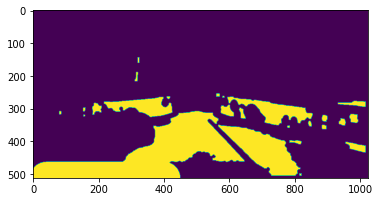

In [73]:
plt.imshow(final_filled)

In [79]:
img[final_filled==255] = (255,60,60)

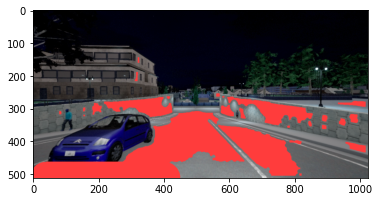

In [80]:
plt.imshow(img)

In [77]:
def _compute_log_likelihood(disp):
#         '''
#         the u_disparity is taken as input to calculate emission probability
#         '''
# quantify the height of obstacles and threshold
    loglike = np.log((disp > 25).astype(np.float)+1e-32)  # adjust to prevent -int
    # adjust to prefer the closest obstacle
    loglike += np.tile(-np.flip(np.arange(disp.shape[1])), (disp.shape[0], 1))*0.1
    return loglike


# Test codes from github

In [38]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/drivable_area_detection
import utilities
import freespace
import stereo

/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/drivable_area_detection


In [39]:
left_path = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/drivable_area_detection/left.png'
right_path = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/drivable_area_detection/right.png'
l_img = cv2.imread(left_path)
r_img = cv2.imread(right_path)

In [40]:
v,u,depth_map,project = freespace.get_free_bound(l_img,r_img)

In [46]:
def all_idx(idx, axis):
    '''
    to get the necessary indices
    '''
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)

In [94]:
ncols = depth_map.max()+1
out = np.zeros(depth_map.shape + (ncols,), dtype=int)
out[all_idx(depth_map, axis=2)] = 1

In [95]:
v_disparity_thresh = v > 100
lines = np.squeeze(cv2.HoughLines(v_disparity_thresh.astype(np.uint8), 1, np.pi/180, 75))

In [96]:
# extracting road planes in a certain range
line = lines[(lines[:, 1] > 1.5) * (lines[:, 1] < 3.0), :]

In [97]:
# if no line matches the criteria, just give out the first found line
if line.size == 0:
    line = lines[0]
else:  # else give the first line that matches the criteria
    line = line[0]
# extract the radius and angle defining the line
    rho = line[0]
    theta = line[1]

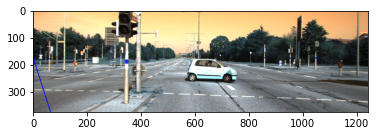

In [98]:
a = np.cos(theta)
b = np.sin(theta)
x0 = a*rho
y0 = b*rho
x1 = int(x0 + 1000*(-b))
y1 = int(y0 + 1000*(a))
x2 = int(x0 - 1000*(-b))
y2 = int(y0 - 1000*(a))

cv2.line(l_img,(x1,y1),(x2,y2),(0,0,255),2)
plt.imshow(l_img)

test image from fb

In [ ]:
path_fb = '/content/drive/MyDrive/Google colab notebooks/test.jpg'

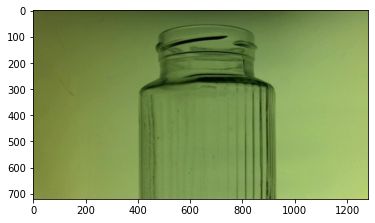

In [ ]:
img = cv2.imread(path_fb)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


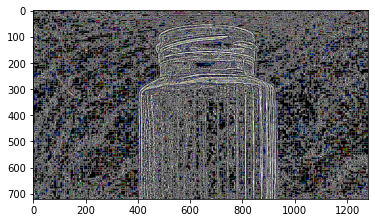

In [ ]:
laplacian = cv2.Laplacian(img,cv2.CV_32F)
plt.imshow(laplacian)

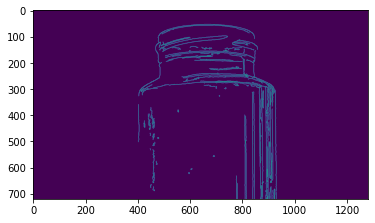

In [ ]:
gray = cv2.imread(path_fb,0)
gray = cv2.cvtColor(gray,cv2.COLOR_BGR2RGB)
cany = cv2.Canny(gray,50,100)
plt.imshow(cany)

In [ ]:
cany.shape

(720, 1280)

In [ ]:
height,width = cany.shape
for i in range(width):
  for j in range(height):
    if cany[j,i] == 0:
      cany[j,i] = 1
    else:
      cany[j,i] = 0
  #take the center of the image, then calculate the distance from center to the edge
  # on the left(because it is not distored by the other edge)
  # then draw the bbx

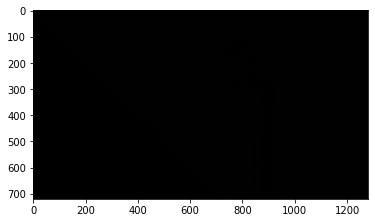

In [ ]:
cany = cv2.cvtColor(cany,cv2.COLOR_BGR2RGB)
plt.imshow(cany)


Idea: for training yoloV4, all images and labels have to put in 1 files, and they have to have the same name

In [ ]:
# path_train = Path('/content/drive/MyDrive/Google colab notebooks/ComputerVision_homework/Carla_Videos/rgb(test)')
# for i in range(len(X_train_val)):
#   img = X_train_val[i]
#   label = Y_train_val[i]
#   cv2.imwrite(path_train,img)
  